### Creditcard fraud 분류 

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv

#### 문제 정의

이 데이터셋은 신용카드 거래에서 발생하는 사기(Fraud) 여부를 판별하는 모델을 개발하는 것을 목표로 합니다. 데이터셋에는 총 284,807건의 거래 데이터가 있으며, 이 중 492건(0.172%)이 사기 거래로 라벨링되어 있습니다. 데이터셋은 매우 불균형(imbalanced)하며, 대부분의 거래가 정상(non-fraud)으로 분류됩니다.


#### 주요 목표
- 이진 분류 문제: 각 거래가 사기(Fraud)인지 정상(Non-Fraud)인지 예측합니다.
- 불균형 데이터 처리: 데이터셋이 불균형하므로, 적절한 데이터 처리 기법(예: 언더샘플링, 오버샘플링, SMOTE 등)을 사용해 모델의 성능을 최적화해야 합니다.
- 모델 평가: 모델의 성능을 평가하기 위해 ROC-AUC, Precision, Recall, F1-Score 등의 지표를 사용할 수 있습니다. 특히, False Positive와 False Negative의 영향을 잘 고려해야 합니다.
#### 데이터 설명
- 피처: 데이터는 PCA(Principal Component Analysis) 변환된 변수들로 구성되어 있으며, 대부분의 피처는 V1, V2, ..., V28로 표현됩니다. 'Time'과 'Amount'는 원래 값이 포함되어 있습니다.
- 레이블: 'Class' 변수는 각 거래의 레이블을 나타내며, 1은 사기 거래, 0은 정상 거래를 의미합니다.

#### 데이터 확인

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('./data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
card_df.shape

(284807, 31)

#### Train data set 분리

In [6]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    X_features = df.iloc[:, :-1]
    y_target = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [10]:
print('학습 데이터 label 값 비율 : ', y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 label 값 비율: ', y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 label 값 비율 :  Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 label 값 비율:  Class
0    99.826785
1     0.173215
Name: count, dtype: float64


#### 평가를 위한 함수 작성

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    cf_matrix = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(cf_matrix)
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

#### Train을 위한 모델 선정

- Logistic Regression
- XGBoost
- LightGBM

### Logistic regression 모델 

In [13]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)

lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1] # (0일 확률, 1일 확률) 에서 1이 될 확률 추출

get_clf_eval(y_test, lr_pred, lr_pred_proba)

confusion matrix
[[85280    15]
 [   47   101]]
Accuracy: 0.9993, Precision: 0.8707, Recall: 0.6824,    F1: 0.7652, AUC:0.9520


### 여러 모델 평가를 위한 함수 생성

In [14]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1] # (0일 확률, 1일 확률) 에서 1이 될 확률 추출
    get_clf_eval(tgt_test, pred, pred_proba)

In [15]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

### 특정 feature 데이터 분포 확인 ('Amount')

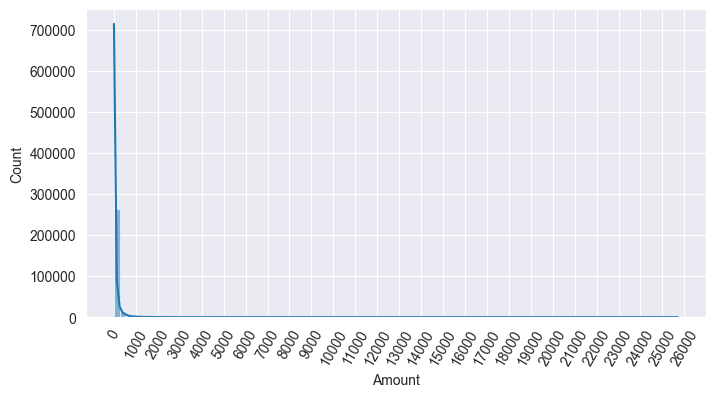

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [19]:
card_df_test = get_preprocessed_df(card_df)
card_df_test.head()

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
